In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import os
import json
import imageio
import matplotlib.pyplot as plt
from tqdm import tqdm
import math

In [19]:
def load_synthetic_images_and_camera_metadata(class_dir, num_classes=8):
    """
    Load images, poses, and camera angle from the synthetic dataset of choice.

    Param:
    - class_dir: Directory for the dataset    
    Returns:
    - images: Tensor of shape [N, H, W, 3]
    - poses: Tensor of shape [N, 4, 4]
    - camera_angle_x: Field of view in the x-direction
    """
    # Gets the path
    json_path = os.path.join(class_dir, "transforms_train.json")
    with open(json_path, 'r') as f:
        data = json.load(f)
    # Loads images and poses into tensors
    images, poses = [], []
    for f in data['frames']:
        img_file = os.path.join(class_dir, f['file_path'] + '.png')
        raw = imageio.v2.imread(img_file)
        if raw.ndim == 3 and raw.shape[2] == 4:
            raw = raw[..., :3]
        elif raw.ndim == 2:
            raw = np.stack([raw, raw, raw], axis=-1)
        img = raw.astype(np.float32) / 255.0
        images.append(img)
        poses.append(np.array(f['transform_matrix'], dtype=np.float32))
    images = torch.tensor(np.stack(images), dtype=torch.float32)
    poses = torch.tensor(np.stack(poses), dtype=torch.float32)
    cam_ang = float(data['camera_angle_x'])
    N, H, W, _ = images.shape
    print(f"Loaded dataset: images: {images.shape}, poses: {poses.shape}, camera_angle_x: {cam_ang:.4f}")

    # Plot example for comparsion
    test_img = images[N-1]
    plt.figure(figsize=(6, 6))
    plt.imshow(test_img.numpy())
    plt.axis("off")
    plt.title("Example image")
    plt.show()
    
    return images, poses, cam_ang

In [20]:
class GaussianSplattingModel(nn.Module):
    """
    3D Gaussian Splatting model.
    """
    def __init__(self, num_gaussians=5000, device='cpu'):
        super(GaussianSplattingModel, self).__init__()
        self.device = device
        self.num_gaussians = num_gaussians
        # Gaussian parameters: positions, scale, rotation, colors, opacity
        # The xyz coordinates of each Gaussian
        self.means = nn.Parameter(torch.randn(num_gaussians, 3, device=device) * 2.0)
        # The scales controls the size of each Gaussian
        self.scales = nn.Parameter(torch.ones(num_gaussians, 3, device=device) * 0.1)
        # Rotation represented as quaternions for 3D rotation(common practice for most rendering models)
        self.rotations = nn.Parameter(torch.zeros(num_gaussians, 4, device=device))
        self.rotations.data[:, 0] = 1.0  # w component = 1 for identity quaternion
        # Random RBG values for each Gaussian for now
        self.colors = nn.Parameter(torch.rand(num_gaussians, 3, device=device))
        # Start with small values for opacities so we can see through them initally
        self.opacities = nn.Parameter(torch.ones(num_gaussians, 1, device=device) * 0.01)
    
    def quaternion_to_rotation_matrix(self, q):
        """Turns our quaternions to rotation matrices"""
        q = F.normalize(q, dim=1)
        w, x, y, z = q[:, 0], q[:, 1], q[:, 2], q[:, 3]
        R = torch.zeros(q.shape[0], 3, 3, device=q.device)
        # Standard quaternion to matrix formula
        R[:, 0, 0] = 1 - 2 * (y**2 + z**2)
        R[:, 0, 1] = 2 * (x * y - w * z)
        R[:, 0, 2] = 2 * (x * z + w * y)
        R[:, 1, 0] = 2 * (x * y + w * z)
        R[:, 1, 1] = 1 - 2 * (x**2 + z**2)
        R[:, 1, 2] = 2 * (y * z - w * x)
        R[:, 2, 0] = 2 * (x * z - w * y)
        R[:, 2, 1] = 2 * (y * z + w * x)
        R[:, 2, 2] = 1 - 2 * (x**2 + y**2)
        
        return R
    
    def compute_covariance_matrices(self):
        """Compute covariance matrices for all Gaussians--what is used to "splat" each Gaussian into the image."""
        rotations = self.quaternion_to_rotation_matrix(self.rotations)
        scales = torch.diag_embed(self.scales**2)
        # For each Gaussian: rotation @ scale @ rotation.transpose or R * S * R^T
        covariances = torch.bmm(torch.bmm(rotations, scales), rotations.transpose(1, 2))
        
        return covariances
    
    def project_gaussians_to_image(self, camera_pose, H, W, focal):
        """
        Splat the 3D Gaussians onto the image plane.
        
        Param:
        - camera_pose: [4, 4], the camera transformation matrix
        - H, W: Image height and width
        - focal: Focal length
        Returns:
        - centers_2d: [num_gaussians, 2], the 2D centers of our projected Gaussians
        - covs_2d: [num_gaussians, 2, 2], the 2D covariance matrices of projections
        - depths: [num_gaussians] the depths of Gaussians from camera
        """
        # Transform Gaussian means into camera space
        R = camera_pose[:3, :3] # Camera rotation
        t = camera_pose[:3, 3] # Camera translation
        means_camera = torch.matmul(self.means, R.t()) + t
        depths = means_camera[:, 2]
        valid_mask = depths > 0 # Only keep points in front

        # Project 3D centers to 2D image coordinates
        centers_2d = torch.zeros(self.num_gaussians, 2, device=self.device)
        centers_2d[:, 0] = focal * means_camera[:, 0] / torch.clamp(means_camera[:, 2], min=1e-10) + W / 2
        centers_2d[:, 1] = focal * means_camera[:, 1] / torch.clamp(means_camera[:, 2], min=1e-10) + H / 2

        # Compute the 3D covariance matrices and project their covariance ellipses to 2D
        covs_3d = self.compute_covariance_matrices()
        covs_camera = torch.bmm(torch.bmm(R.expand(self.num_gaussians, 3, 3), covs_3d), R.expand(self.num_gaussians, 3, 3).transpose(1, 2))
        J = torch.zeros(self.num_gaussians, 2, 3, device=self.device) # Jacobian matrix (helpful to maintain Gaussian's ellipsoidal shapes )
        Z = torch.clamp(means_camera[:, 2], min=1e-10)
        J[:, 0, 0] = focal / Z
        J[:, 0, 2] = -focal * means_camera[:, 0] / (Z * Z)
        J[:, 1, 1] = focal / Z
        J[:, 1, 2] = -focal * means_camera[:, 1] / (Z * Z)
        covs_2d = torch.bmm(torch.bmm(J, covs_camera), J.transpose(1, 2))
        covs_2d = covs_2d + torch.eye(2, device=self.device).unsqueeze(0) * 1e-6 # To avoid division by 0
        
        return centers_2d, covs_2d, depths, valid_mask
    
    def render_image(self, camera_pose, H, W, focal, bg_color=None):
        """
        Render an image by splatting all our Gaussians onto the image plane.
        
        Params:
        - camera_pose: [4, 4], the camera transformation matrix
        - H, W: Image height and width
        - focal: Focal length
        - bg_color: Background color(set to black)
        Returns:
        - rendered_image: [H, W, 3], rendered image
        """
        if bg_color is None:
            bg_color = torch.zeros(3, device=self.device) # Default black
        else:
            bg_color = torch.tensor(bg_color, device=self.device)
        # Get each gaussian blob's 2d center, covariance, depth and a mask that tells us which are in front of the camera
        centers_2d, covs_2d, depths, valid_mask = self.project_gaussians_to_image(camera_pose, H, W, focal)
        rendered_image = torch.zeros(H, W, 3, device=self.device)
        alpha_acc = torch.zeros(H, W, 1, device=self.device)
        # Sort Gaussians by depth and remove those behind the camera
        valid_indices = torch.where(valid_mask)[0]
        if len(valid_indices) == 0:
            return torch.ones(H, W, 3, device=self.device) * bg_color.unsqueeze(0).unsqueeze(0)
        sorted_indices = valid_indices[torch.argsort(depths[valid_indices], descending=True)]
        
        # Iterate through sorted Gaussians to determine which pixels it affects and blend its color+opacity into the image.
        for idx in sorted_indices:
            center = centers_2d[idx]
            cov = covs_2d[idx]
            color = self.colors[idx]
            opacity = torch.sigmoid(self.opacities[idx, 0])
            # Skip Gaussians skip if far outside the image
            if (center[0] < -W/2 or center[0] > W*1.5 or 
                center[1] < -H/2 or center[1] > H*1.5):
                continue
            # Use a bounding box for speed and efficiency(we really need it lol)
            std_dev = torch.sqrt(torch.diagonal(cov) + 1e-10)
            radius = 3 * torch.max(std_dev).item()
            # Compute bounding box
            min_x = max(0, int(center[0] - radius))
            max_x = min(W, int(center[0] + radius + 1))
            min_y = max(0, int(center[1] - radius))
            max_y = min(H, int(center[1] + radius + 1))
            if min_x >= max_x or min_y >= max_y: # Skip if bounding box is empty
                continue
            y_coords, x_coords = torch.meshgrid( torch.arange(min_y, max_y, device=self.device), torch.arange(min_x, max_x, device=self.device), indexing='ij')
            box_coords = torch.stack([x_coords.flatten(), y_coords.flatten()], dim=1)
            diff = box_coords - center.unsqueeze(0)
            try: # we need this in the case the covariance doesn't have a inverse (singular) 
                inv_cov = torch.inverse(cov)
            except:
                inv_cov = torch.diag(1.0 / (torch.diagonal(cov) + 1e-10))
            exponent = -0.5 * torch.sum(torch.matmul(diff, inv_cov) * diff, dim=1)
            gauss_val = torch.exp(exponent) * opacity
            gauss_val = gauss_val.reshape(max_y - min_y, max_x - min_x, 1) # For broadcasting
            color_contribution = color.unsqueeze(0).unsqueeze(0) * gauss_val
            # We use Alpha‑blending here it lets us layer semi‑transparent Gaussians correctly
            current_alpha = 1.0 - alpha_acc[min_y:max_y, min_x:max_x]
            alpha_acc[min_y:max_y, min_x:max_x] = alpha_acc[min_y:max_y, min_x:max_x] + gauss_val * current_alpha
            rendered_image[min_y:max_y, min_x:max_x] = (rendered_image[min_y:max_y, min_x:max_x] + color_contribution * current_alpha)
        
        # For pixels that may be partially or not covered at all we cover it with the background
        rendered_image = rendered_image + bg_color.unsqueeze(0).unsqueeze(0) * (1.0 - alpha_acc)
        return rendered_image

In [21]:
def train_gaussian_splatting(model, images, poses, camera_angle_x, epochs=100, lr=0.01):
    """
    Trains the Gaussian Splatting model.
    
    Params:
    - model: GaussianSplattingModel
    - images: [N, H, W, 3], the training images
    - poses: [N, 4, 4], the camera poses
    - camera_angle_x: Field of view in x-direction
    - epochs: Number of training epochs
    - lr: Learning rate
    """
    N, H, W, _ = images.shape
    focal = 0.5 * W / np.tan(0.5 * camera_angle_x)

    optimizer = torch.optim.Adam([
        {'params': model.means, 'lr': lr},
        {'params': model.scales, 'lr': lr},
        {'params': model.rotations, 'lr': lr * 0.1},  # Lower learning rate for rotations
        {'params': model.colors, 'lr': lr},
        {'params': model.opacities, 'lr': lr * 0.1}  # Lower learning rate for opacities
    ])
    indices = torch.randperm(N)
    losses = []  
    for epoch in range(epochs):
        epoch_loss = 0.0
        indices = torch.randperm(N)
        # Process each image
        for i in tqdm(range(N), desc=f"Epoch {epoch+1}/{epochs}"):
            idx = indices[i].item()
            target_image = images[idx].to(model.device)
            pose = poses[idx].to(model.device)
            rendered_image = model.render_image(pose, H, W, focal)
            loss = F.mse_loss(rendered_image, target_image)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # To keep the scales positive
            with torch.no_grad():
                model.scales.data.clamp_(min=0.001, max=1.0)
                model.rotations.data = F.normalize(model.rotations.data, dim=1) # Normalize quaternions
                model.colors.data.clamp_(0, 1) # Clamp colors to [0, 1]
            epoch_loss += loss.item()
        avg_loss = epoch_loss / N
        losses.append(avg_loss)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.6f}")

        # Show the splat progress every 5 epochs
        if (epoch + 1) % 5 == 0 or epoch == 0:
            with torch.no_grad():
                test_pose = poses[0].to(model.device)
                test_render = model.render_image(test_pose, H, W, focal)
                plt.figure(figsize=(12, 6))
                plt.subplot(1, 2, 1)
                plt.imshow(images[0].cpu().numpy())
                plt.title("Target Image")
                plt.axis('off')
                plt.subplot(1, 2, 2)
                plt.imshow(test_render.cpu().numpy())
                plt.title(f"Rendered Image (Epoch {epoch+1})")
                plt.axis('off')
                plt.tight_layout()
                plt.show()
    
    # Plot the loss curve
    plt.figure(figsize=(10, 5))
    plt.plot(losses)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()
    
    return model

In [ ]:
def render_novel_views(model, output_dir, H, W, focal, poses, num_frames=30):
    """
    Render novel views by creating a spiral path around poses[0].

    Parameters:
    - model: Trained GaussianSplattingModel
    - output_dir: Directory to save rendered images
    - H, W: Image height and width
    - focal: Focal length
    - poses: [N, 4, 4] tensor of camera poses (torch.Tensor)
    - num_frames: Number of novel views to render
    """
    os.makedirs(output_dir, exist_ok=True)
    model.eval()

    base_pose = poses[0].to(model.device)  # Use the first pose as center

    def create_spiral_poses_around(pose_center, radius=2.0, height=0.5, num_frames=30):
        poses = []
        for i in range(num_frames):
            angle = 2 * math.pi * i / num_frames
            # Spiral offset 
            offset = torch.tensor([
                radius * math.cos(angle),
                radius * math.sin(angle),
                height * math.sin(angle * 0.5)
            ], device=pose_center.device)

            # Transform to world coordinates
            world_pos = pose_center[:3, 3] + pose_center[:3, :3] @ offset

            # Look-at is the original camera position
            look_at = pose_center[:3, 3]
            forward = (look_at - world_pos)
            forward = forward / torch.norm(forward)

            # Up vector from base pose
            up = pose_center[:3, 1]
            right = torch.cross(up, forward)
            right = right / torch.norm(right)
            up = torch.cross(forward, right)

            R = torch.stack([right, up, forward], dim=1)
            T = world_pos

            pose = torch.eye(4, device=pose_center.device)
            pose[:3, :3] = R
            pose[:3, 3] = T
            poses.append(pose)
        return poses

    # Generate the spiral path
    spiral_poses = create_spiral_poses_around(base_pose, radius=2.0, height=0.5, num_frames=num_frames)

    with torch.no_grad():
        for i, camera_pose in enumerate(spiral_poses):
            rendered_image = model.render_image(camera_pose, H, W, focal)
            img_np = rendered_image.cpu().numpy()
            img_np = np.clip(img_np, 0, 1)
            img_uint8 = (img_np * 255).astype(np.uint8)
            imageio.imwrite(os.path.join(output_dir, f"frame_{i:03d}.png"), img_uint8)

            # visualize every 5th frame
            if i % 5 == 0:
                plt.figure(figsize=(8, 8))
                plt.imshow(img_np)
                plt.title(f"Frame {i}/{num_frames}")
                plt.axis('off')
                plt.show()

    print(f"Rendered {num_frames} novel views to {output_dir}")

In [ ]:
def main_pipeline(data_dir="data/nerf_synthetic/drums", output_dir="gaussian_output_drums"):
    """
    Main pipeline for Gaussian Splatting:
    1. Load data
    2. Create model
    3. Train model
    4. Render novel views
    """
    images, poses, camera_angle_x = load_synthetic_images_and_camera_metadata(data_dir)
    N, H, W, _ = images.shape
    focal = 0.5 * W / np.tan(0.5 * camera_angle_x)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Tested on laptop & oscar
    print(f"Using device: {device}")
    num_gaussians = 1000 # Honestly our most limiting factor
    model = GaussianSplattingModel(num_gaussians=num_gaussians, device=device)
    epochs = 50
    model = train_gaussian_splatting(model, images, poses, camera_angle_x, epochs=epochs)
    render_novel_views(model, output_dir, H, W, focal, poses, num_frames=30)
    
    print("Pipeline completed successfully!")

Loaded dataset: images: torch.Size([100, 800, 800, 3]), poses: torch.Size([100, 4, 4]), camera_angle_x: 0.6194


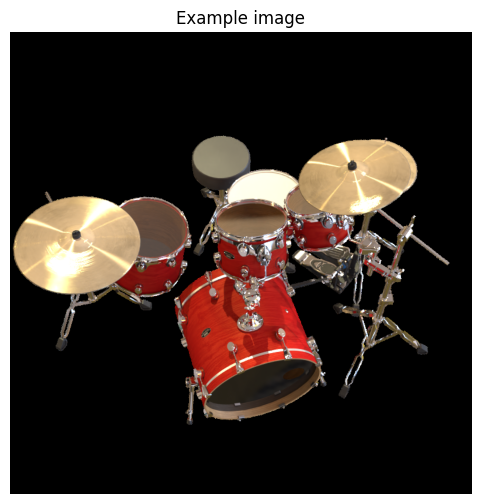

Using device: cpu


Epoch 1/30:  50%|█████     | 50/100 [00:05<00:05,  8.68it/s]


KeyboardInterrupt: 

In [24]:
if __name__ == "__main__":
    main_pipeline()